In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords

"""
This is just going to make data to turn into audio.  sentence splitting can happen here i think.
"""

'\nThis is just going to make data to turn into audio.  sentence splitting can happen here i think.\n'

In [2]:
cuss_words = [
    "fuck"
    ,"fucking"
    ,"ass"
    ,"bitch"
    ,"dick"
    ,"fag"
    ,"faggot"
    ,"nigger"
    ,"shit"
    ,"cunt"
    ,"whore"
    ,"cock"
    ,"pussy"
    ,"cocksucker"
    
]

In [3]:
stops = set(stopwords.words('english'))

In [4]:
data = pd.read_csv('dota2_chat_messages.csv')
data['text'] = data['text'].apply(str)
data['text'] = data['text'].apply(str.lower)

In [40]:
def maxscii(string):
    """
    returns true if the proportion of characters that are in [a-z] or [A-Z] are over cutoff
    """
    letter_ascii = [i for i in range(65,91)] + [i for i in range(97,123)]
    string_ascii = [ord(i) for i in str(string)]
    letter_list = [ 1 if i in letter_ascii else 0 for i in string_ascii]
    
    return float(sum(letter_list))/float(len(letter_list))

def space_ratio(string):
    str_string = str(string)
    return str_string.count(" ")/len(str_string)
    
def total_stop_words(string,stop_words):
    """
    count how many english stop words are present
    returns word level ratio
    """
    text_list = string.split(" ")
    stop_counts = len([i for i in text_list if i in stop_words])
    return stop_counts/len(text_list)

def augment_with_non_final_cuss_words(df,cuss_words):
    """
    This is a data augmentation function that looks for cuss_words in the middle of the sentence, slices the sentence 
    and makes another sentence with a terminal position cussword. 
    """
    word_split = [i.split(' ')[:-1] for i in df] #not the first and not the last

    truth_table = [ [x  in cuss_words for x in i ] for i in word_split  ] ## all but last
    final_idx = [[j for j,k in enumerate(i) if k] for i in truth_table]
    extra_words = [i for i in list(zip(word_split, final_idx)) if len(i[1]) > 0]
    df_aug = pd.Series( [' '.join(i[0][:j+1]) for i in extra_words for j in i[1]])
    return pd.concat([df,df_aug])

def bleep(string,cuss_words):
    """
    more robust than just matching.  this sees if any of the cusswords exist in the last word
    so, fucko will match with fuck.  
    """
    last_word = string.split(' ')[-1]
    return any([i in last_word for i in cuss_words ])
    

In [6]:
data['maxscii'] = data.apply(lambda x : maxscii(x['text']), axis =1) #proportion of letters in text
data['len'] = data.apply(lambda x : len(str(x['text'])), axis =1) #len in char
data['space_ratio'] = data.apply(lambda x: space_ratio(x['text']), axis = 1)
data['stop_percent'] = data.apply(lambda x : total_stop_words(x['text'],stops), axis = 1 )

<AxesSubplot:>

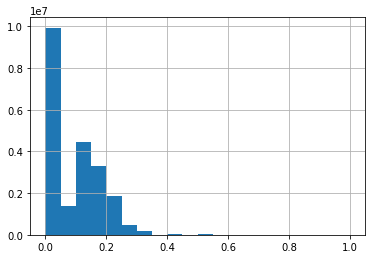

In [7]:
data["space_ratio"].hist(bins = 20)

<AxesSubplot:>

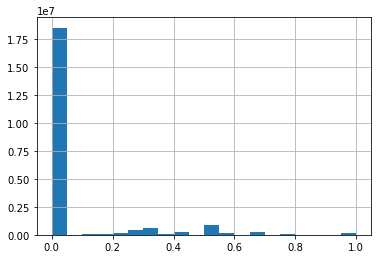

In [8]:
data["stop_percent"].hist(bins = 20)

<AxesSubplot:>

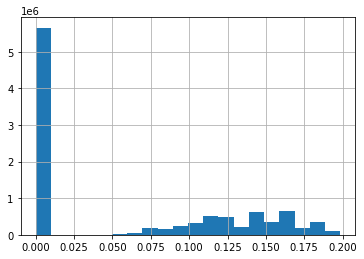

In [9]:
data.loc[data['maxscii'] > 0.8]['space_ratio'].hist(bins=20)

array([[<AxesSubplot:title={'center':'maxscii'}>,
        <AxesSubplot:title={'center':'len'}>]], dtype=object)

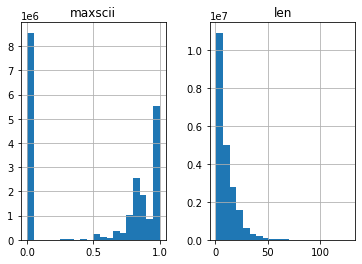

In [10]:
data[['maxscii','len']].hist(bins = 20) ## looks like above 0.8 will do nice

<AxesSubplot:xlabel='maxscii', ylabel='len'>

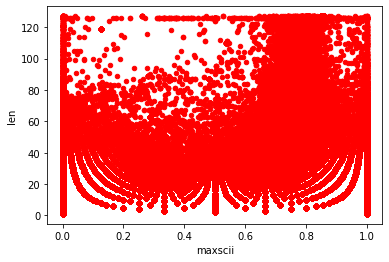

In [11]:
data.plot.scatter(x='maxscii',y='len',c='red')

In [12]:
good_data = data['text']
good_data = good_data.loc[data['maxscii']>0.8]
good_data = good_data.loc[data['len']>20]
good_data = good_data.loc[data['space_ratio']>0.05]
good_data = good_data.loc[data['stop_percent']>0.2] #0 was too low, was getting tagalog


In [28]:
good_data_augmented = augment_with_non_final_cuss_words(good_data,cuss_words)

In [43]:
labeled = pd.DataFrame(good_data_augmented)
labeled[1] = labeled.apply(lambda x : bleep(x[0],cuss_words),axis = 1)

In [48]:
labeled[1].value_counts(), labeled

(False    422675
 True      49999
 Name: 1, dtype: int64,
                                  0      1
 131          worst hook in history  False
 181        man that silence on axe  False
 212    you better call your mom od  False
 213          u need her breastfeed  False
 331          remember me last game  False
 ...                            ...    ...
 34537       we won bot you fucking   True
 34538              are you fucking   True
 34539            you are a fucking   True
 34540                         fuck   True
 34541                shut the fuck   True
 
 [472674 rows x 2 columns])

In [49]:
labeled.to_csv("labeled_augmented.csv")

In [2]:
pd.read_csv('labeled_augmented.csv')

,Unnamed: 0,0,1
0,131,worst hook in history,False
1,181,man that silence on axe,False
2,212,you better call your mom od,False
3,213,u need her breastfeed,False
4,331,remember me last game,False
...,...,...,...
472669,34537,we won bot you fucking,True
472670,34538,are you fucking,True
472671,34539,you are a fucking,True
472672,34540,fuck,True
